In [1]:
import csv
import numpy as np
from spectra import Spectra, Pigment
import matplotlib.pyplot as plt
import numpy.typing as npt

## Load ink spectra samples

In [2]:
primary_fns = [
    "000",
    "001",
    "010",
    "100",
    "011",
    "110",
    "101",
    "111",
]

mixed_fns = [
    "10 10 10",
    "25 00 50",
    "33 33 33",
    "33 60 00",
    "33 66 100",
    "50 00 100",
    "50 25 10",
    "66 66 66",
    "90 90 100"
]

In [3]:
spectra_primaries_dict = {}
spectra_mixed_dict = {}
wavelengths = np.arange(400, 701, 10)

for fn in primary_fns:
    with open(f'PrintColors/{fn}.csv') as csvf:
        spamreader = csv.reader(csvf, delimiter=';')
        for i, row in enumerate(spamreader):
            if i == 4:
                color_data = np.array(row[33:],dtype=float)
                spectra = Spectra(data=color_data, wavelengths=wavelengths)
                spectra_primaries_dict[fn] = spectra
                
for fn in mixed_fns:
    with open(f'PrintColors/{fn}.csv') as csvf:
        spamreader = csv.reader(csvf, delimiter=';')
        for i, row in enumerate(spamreader):
            if i == 4:
                color_data = np.array(row[33:],dtype=float)
                spectra = Spectra(data=color_data, wavelengths=wavelengths)
                spectra_mixed_dict[fn] = spectra

In [4]:
spectra_primaries_dict

{'000': <spectra.Spectra at 0x1264cdf50>,
 '001': <spectra.Spectra at 0x126443890>,
 '010': <spectra.Spectra at 0x120480ad0>,
 '100': <spectra.Spectra at 0x12033e610>,
 '011': <spectra.Spectra at 0x1262a0d10>,
 '110': <spectra.Spectra at 0x12646cf90>,
 '101': <spectra.Spectra at 0x1204b8c10>,
 '111': <spectra.Spectra at 0x120327c10>}

In [5]:
def neugebauer_mix(percentages, n=50):
    percentages = np.array(percentages, dtype=float) 
    output = Spectra(wavelengths=wavelengths, data=np.zeros_like(wavelengths))
    for key, spectra in spectra_primaries_dict.items():
        binary_vector = np.array(list(map(int, key)))
        weight = np.prod(binary_vector * percentages + (1 - binary_vector) * (1 - percentages))
        output += weight * (spectra ** (1 / n))
    return (output ** n)


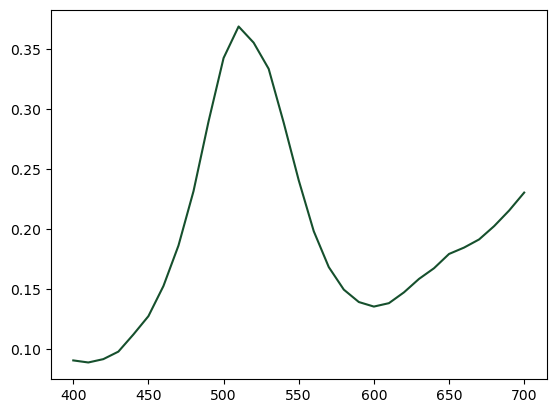

In [6]:
mixed = neugebauer_mix(np.array([1, 0, 1]))
mixed.plot()

## Find best Neugebauer Coefficient

In [7]:
def compare_spectra(spectra1: Spectra, spectra2: Spectra):
    return np.sum((spectra1.data() - spectra2.data()) ** 2)

0.03646963356548787


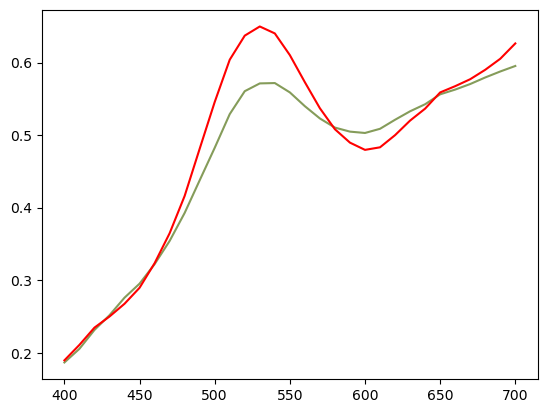

In [8]:
figt, axt = plt.subplots()

l = '25 00 50'

concentrations = np.array(l.split(" "), dtype=float) / 100
theoretical = neugebauer_mix(concentrations)
observed = spectra_mixed_dict[l]

score = compare_spectra(theoretical, observed)
print(score)
theoretical.plot(ax=axt)
observed.plot(ax=axt, color='r')
# spectra_primaries_dict["100"].plot(ax=axt)
# spectra_primaries_dict["001"].plot(ax=axt)
plt.show()

In [108]:
len(spectra_mixed_dict)

9

<IPython.core.display.Javascript object>


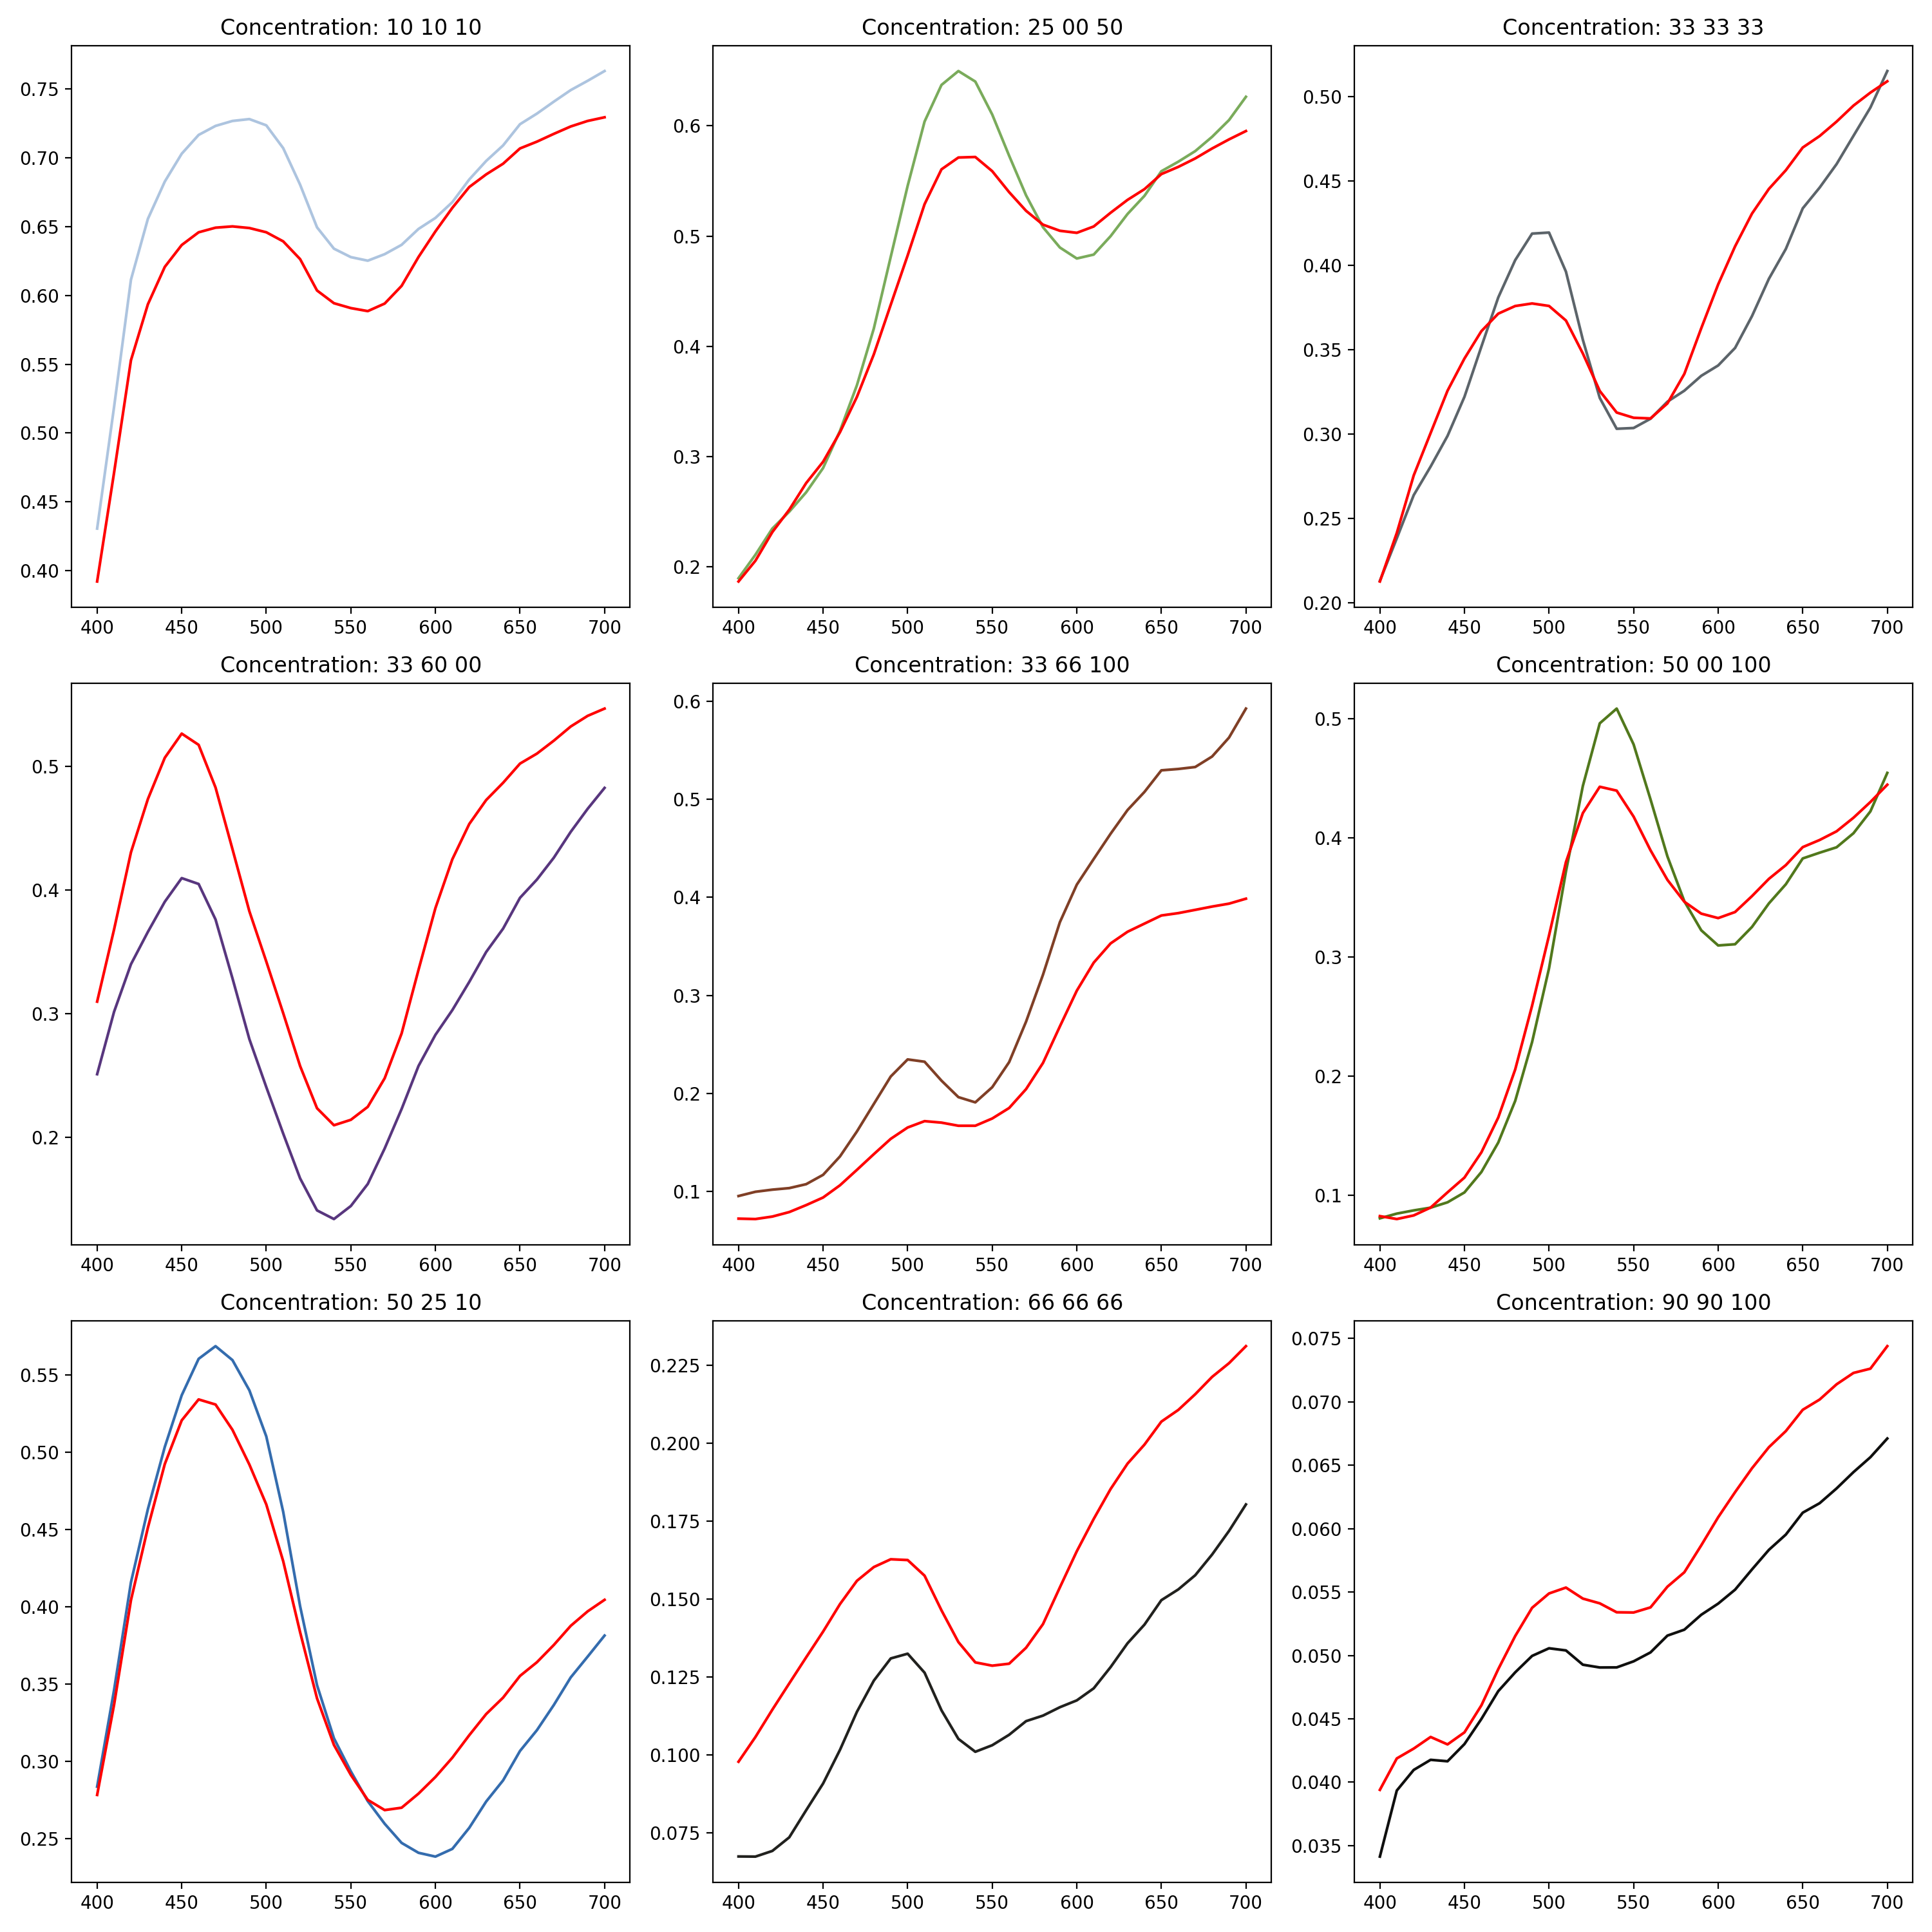

In [111]:

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()  # Flatten the axes array for easy iteration

for i, (percentage, observed) in enumerate(spectra_mixed_dict.items()):
    axi = axes[i]
    concentrations = np.array(percentage.split(" "), dtype=float) / 100
    theoretical = neugebauer_mix(concentrations)
    
    observed.plot(ax=axi)  # Assuming observed is a DataFrame or Series
    theoretical.plot(ax=axi, color='red')  # Dash line for theoretical
    
    # Set title as the concentrations
    axi.set_title(f"Concentration: {percentage}")
    
    # Other customizations, if any, can be done here

# Adjust layout
plt.tight_layout()
fig.savefig("neugebauer_outcomes.png", dpi=300, bbox_inches='tight')

plt.show()

In [112]:
for n in [1, 1.5, 2, 10, 25, 50, 100, 500]:
    worst_score = -1
    for percentage, observed in spectra_mixed_dict.items():
        concentrations = np.array(percentage.split(" "), dtype=float) / 100
        theoretical = neugebauer_mix(concentrations, n=n)
        score = compare_spectra(theoretical, observed)
        worst_score = max(worst_score, score)
    print(n, worst_score)

1 1.009620973551177
1.5 0.7139889161678659
2 0.5825813974583851
10 0.3233977363739882
25 0.2921300557805608
50 0.28217325827789874
100 0.2842382062150319
500 0.291999337847898


So we are going with `n=50`. This is not only contrary to all the literature on the subject I have read, it is totally incoherent. But it works and we will iterate on it being true for now.

Nevermind found basis in the literature!! 


> A minimum is clearly displayed in the case of the coated paper at n = 3.5, whereas the curve asymptotically decreases in the case of the **office paper**, which indicated that the **optimal n tends to infinity** (in practice, we can set n to 20 or 100)

Hébert, Mathieu. (2014). Yule-Nielsen effect in halftone prints: Graphical analysis method and improvement of the Yule-Nielsen transform. Proc SPIE. 9015. 90150R. 10.1117/12.2037370. 

## Trichromat Ink Gamut Metamers

In [10]:
from metamers import Cone, Observer
from models import gaussian

In [11]:
def remove_trailing_nans(arr):
    mask = np.any(np.isnan(arr), axis=1)
    idx = np.where(mask)[0]
    if idx.size > 0:
        last_valid_idx = np.where(~mask)[0][-1]
        return arr[:last_valid_idx + 1]
    return arr

cone_data = np.genfromtxt('linss2_10e_1.csv', delimiter=',')

l_cone = Cone(cone_data[:311, [0, 1]])
m_cone = Cone(cone_data[:311, [0, 2]])
s_cone = Cone(remove_trailing_nans(cone_data[:311, [0, 3]]))



shift = 15
r = [(w,1e-4) for w in m_cone.wavelengths() if w < m_cone.wavelengths()[0]+shift] + \
        [(w+shift,v) for (w,v) in m_cone.reflectance if w+shift <= m_cone.wavelengths()[-1]]
q_cone = Cone(reflectance=np.array(r))

trichromat = Observer([s_cone, m_cone, l_cone], min_transition_size=10)
tetrachromat = Observer([s_cone, m_cone, q_cone, l_cone], min_transition_size=10)

In [12]:
_tri_ink_gamut = {}

# primaries at start for convenience
for i, lms in enumerate([trichromat.observe(spectra) for spectra in spectra_primaries_dict.values()]):
    cmy = tuple(map(lambda x: int(100 * float(x)), primary_fns[i]))
    _tri_ink_gamut[cmy] = lms

for c in np.arange(0, 1.1, 0.1):
    for m in np.arange(0, 1.1, 0.1):
        for y in np.arange(0, 1.1, 0.1):
            mixed_spectra = neugebauer_mix(np.array((c,m,y)))
            tristimulus = trichromat.observe(mixed_spectra)
            _tri_ink_gamut[(int(100 * c), int(100 * m), int(100 *y))] = tristimulus

TRI_INK_GAMUT = np.array(list(_tri_ink_gamut.values()))

In [13]:
_tri_ink_gamut[(60, 40, 50)]

array([0.22154036, 0.22631481, 0.22599891])

In [14]:
from collections import defaultdict

def furthest_metamers(points, axis, stepsize=0.05):
    buckets = defaultdict(list)
    
    for idx, point in enumerate(points):
        key = tuple([int(x / stepsize) for i, x in enumerate(point) if i != axis])
        buckets[key].append(idx)

        
    max_dist = -1
    max_key = None
    
    for key, idxs in buckets.items():
        qs = [points[idx][axis] for idx in idxs]
        span_qs = max(qs) - min(qs)
        if span_qs > max_dist:
            max_dist = span_qs
            max_key = key

    
    thickest_indices = buckets[max_key]
    thickest_qs = [points[idx][axis] for idx in thickest_indices]
    (max_q, idx_max_q) = max(zip(thickest_qs, thickest_indices))
    (min_q, idx_min_q) = min(zip(thickest_qs, thickest_indices))

    print(idx_max_q, idx_min_q)
#     print(points[idx_max_q], points[idx_min_q])
    
    arr = np.abs(points[idx_min_q] - points[idx_max_q])
    return arr[axis] / max(arr[0:axis])

In [15]:
furthest_metamers(TRI_INK_GAMUT, 2)

96 1217


6.070739832095332

<IPython.core.display.Javascript object>


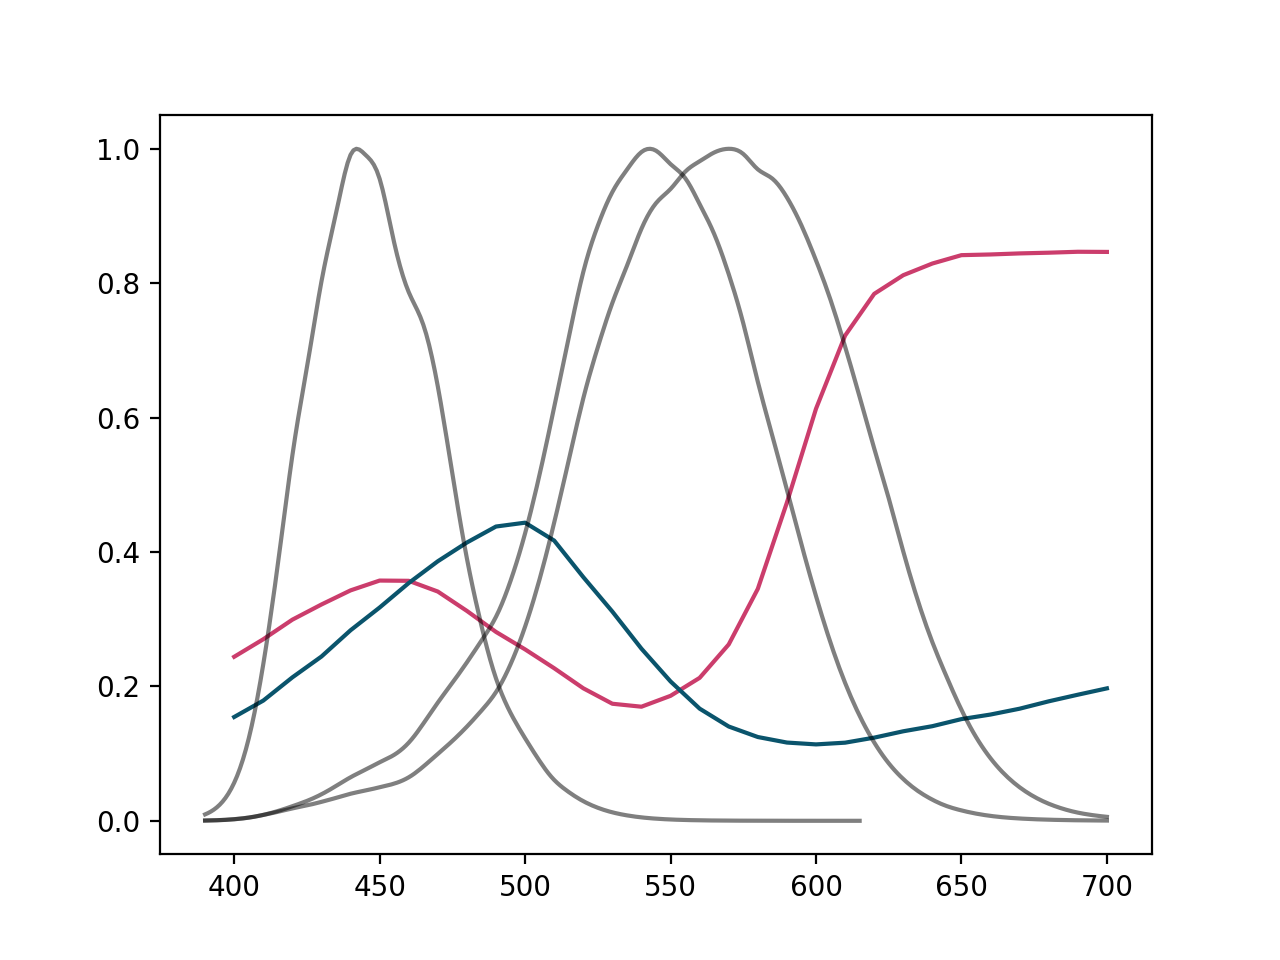

In [92]:
print(trichromat.observe(neugebauer_mix((0, 0.8, 0.2))))
print(trichromat.observe(neugebauer_mix((1, 0, 0.4))))

[0.32562093 0.2828104  0.38907401]
[0.31107413 0.25244226 0.20471693]


its so beautiful

I;m crying the pieces are fr coming together. Now for heart break :,)

## Let's compare those metamers to recorded data

<IPython.core.display.Javascript object>


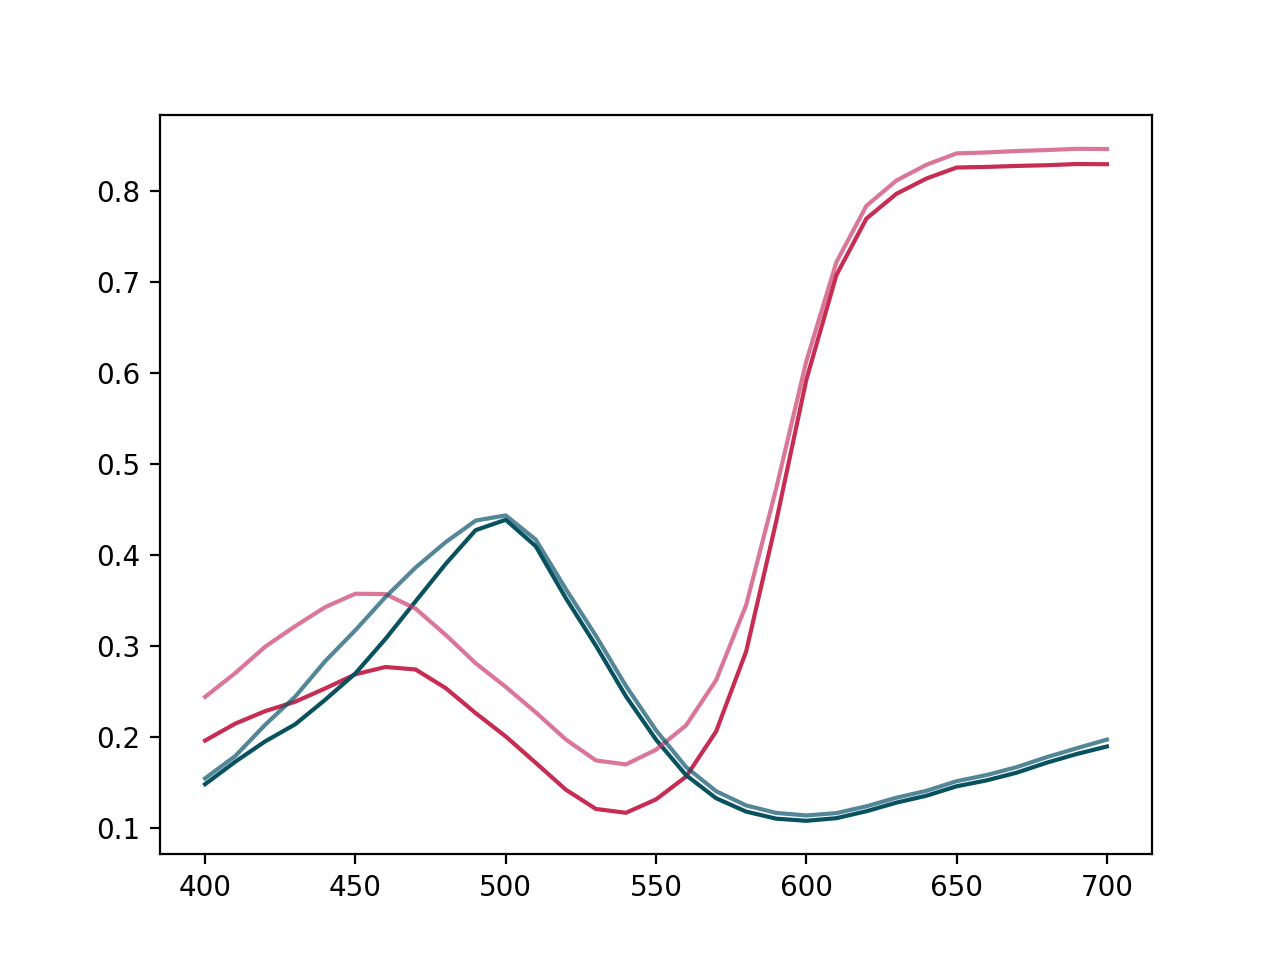

[0.24962781 0.23102962 0.34572796]
[0.27769814 0.24167329 0.19583424]


In [107]:
fig2, ax2 = plt.subplots()

for fn in ["00 80 20", "100 00 40"]:
    with open(f'PrintColors/{fn}.csv') as csvf:
        spamreader = csv.reader(csvf, delimiter=';')
        for i, row in enumerate(spamreader):
            if i == 4:
                color_data = np.array(row[33:],dtype=float)
                spectra = Spectra(data=color_data, wavelengths=wavelengths)
                print(trichromat.observe(spectra))
                spectra.plot(ax=ax2)
                
neugebauer_mix((0, 0.8, 0.2)).plot(ax=ax2, alpha=0.7)
neugebauer_mix((1, 0, 0.4)).plot(ax=ax2, alpha=0.7)

# l_cone.plot(ax=ax2,color='black', alpha=0.5)
# m_cone.plot(ax=ax2,color='black', alpha=0.5)
# s_cone.plot(ax=ax2,color='black', alpha=0.5)
plt.show()

plt.show()

## Approximating theoretical inks

<IPython.core.display.Javascript object>


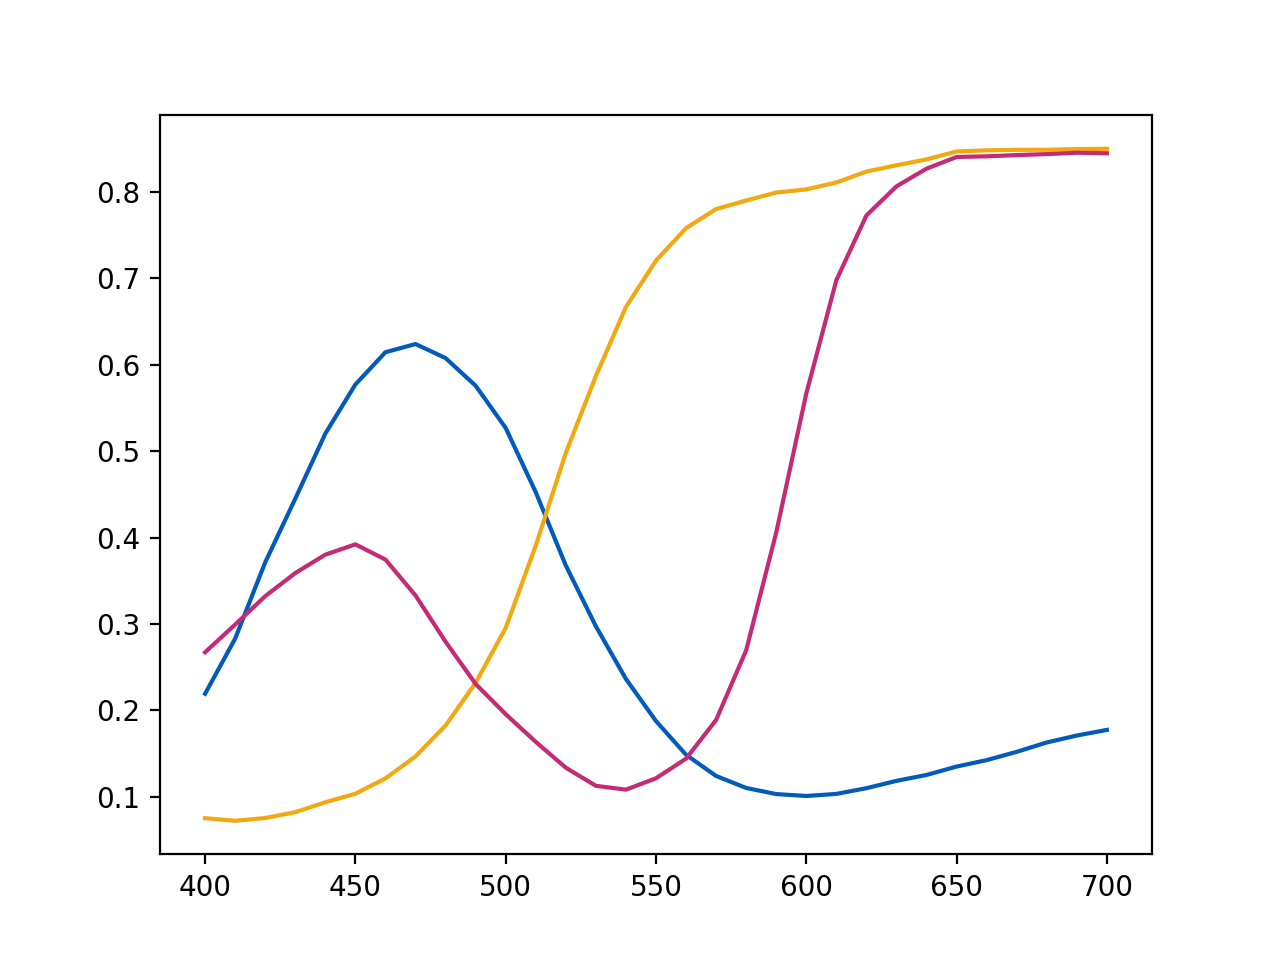

In [118]:
def shift(pigment : Pigment,shiftAmount : int):
    r = [(w,pigment.reflectance[0][1]) for w in pigment.wavelengths() if w < pigment.wavelengths()[0]+shiftAmount] 
    r += [(w+shiftAmount,v) for (w,v) in pigment.reflectance if w+shiftAmount <= pigment.wavelengths()[-1] and w+shiftAmount >= pigment.wavelengths()[0]]
    r += [(w,pigment.reflectance[-1][1]) for w in pigment.wavelengths() if w > pigment.wavelengths()[-1]+shiftAmount]
    return Pigment(reflectance=np.array(r))

cyan = spectra_primaries_dict["100"]
magenta = spectra_primaries_dict["010"]
yellow = spectra_primaries_dict["001"]
green = shift(spectra_primaries_dict["100"],50)
orange = shift(spectra_primaries_dict["010"],-50)
pink = shift(spectra_primaries_dict["010"],-20)
figc, axc = plt.subplots()
for spectra in [cyan, yellow,magenta]:
    spectra.plot(color=np.clip(spectra.to_rgb(),0,1), ax=axc)
    
figc.savefig("cmy.png")

Kubelka-Munk will be used to approximate the Neugabauer superpositions. See **Predicting reflectances of Neugebauer primaries by relying on separately measured ink transmittances (2012)** and **The Performance of Computerized Spectrum Color Matching Based on Kubelka-Munk Theory and its Color Rendering on Offset Ink Sets (2010)** for a deeper discussion on this.

For this simplified model, I'm just going to assume that any combination of 3+ inks renders as black. This is partly because KM theory seems to be extremely poor for the prediciton of 3+ inks, and also that this assumption is largely true (e.g. in the case of CMY) -- at the least, 3+ inks is going to be usually rather dark.

In [18]:
def k_s_from_pigments(pigments):
    k_list = []
    s_list = []

    for pigment in pigments:
        if not isinstance(pigment, Pigment):
            pigment = Pigment(reflectance=pigment)
        k, s = pigment.get_k_s()
        k_list.append(k)
        s_list.append(s)

    k_matrix = np.column_stack(k_list)
    s_matrix = np.column_stack(s_list)

    return k_matrix, s_matrix

In [19]:
def km_mix(pigments , concentrations = None):
    K_matrix, S_matrix = k_s_from_pigments(pigments)
    wavelengths = pigments[0].wavelengths()

    if not concentrations:
        concentrations = np.array([1 / len(pigments)] * len(pigments) )
        
    K_mix = K_matrix @ concentrations
    S_mix = S_matrix @ concentrations
    
    k = np.column_stack((wavelengths, K_mix))
    s = np.column_stack((wavelengths, S_mix))
    
    return Pigment(k=k, s=s)

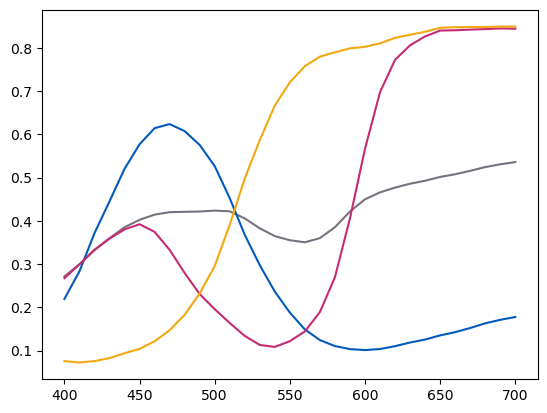

In [20]:
figp, axp = plt.subplots()
km_mix(
[
    spectra_primaries_dict["100"],
    spectra_primaries_dict["010"],
    spectra_primaries_dict["001"]
]
).plot()
spectra_primaries_dict["100"].plot(ax=axp)
spectra_primaries_dict["010"].plot(ax=axp)
spectra_primaries_dict["001"].plot(ax=axp)

plt.show()

In [21]:
expanded_primaries_dict = {}
# Cyan, Magenta, Yellow, Green, Orange, Pink
expanded_inks_dict = {
    "100000": spectra_primaries_dict["100"],
    "010000": spectra_primaries_dict["010"],
    "001000": spectra_primaries_dict["001"],
    "000100": green,
    "000010": orange, 
    "000001": pink
}

In [22]:
expanded_primaries_dict['000000'] = spectra_primaries_dict['000']
expanded_primaries_dict['101000'] = spectra_primaries_dict['101']
expanded_primaries_dict['110000'] = spectra_primaries_dict['110']
expanded_primaries_dict['011000'] = spectra_primaries_dict['011']
expanded_primaries_dict['111000'] = spectra_primaries_dict['111']

# Fill all 2^6 = 64 primaries as either KM mix of two colors or black.
for i in range(1, 64): 
    binary_str = format(i, '06b')  # Convert integer to 7-bit binary string
    inks_to_mix = []
    
    for j, bit in enumerate(binary_str):
        if bit == '1':
            key = '0' * j + '1' + '0' * (5 - j)
            inks_to_mix.append(expanded_inks_dict[key])
            
    if len(inks_to_mix) < 3:
        mixed_ink = km_mix(inks_to_mix)
        expanded_primaries_dict[binary_str] = mixed_ink
    elif binary_str not in expanded_primaries_dict:
        expanded_primaries_dict[binary_str] = spectra_primaries_dict['111']

## Calculating Expanded Gamut

In [23]:
from itertools import combinations, product
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

In [24]:
def expanded_neugebauer_mix(percentages, n=50):
    # set for extended_parimaries_dict with 6 primaries
    # e.g. percentages is a list of 6 items
    percentages = np.array(percentages, dtype=float) 
    output = Spectra(wavelengths=wavelengths, data=np.zeros_like(wavelengths))
    for key, spectra in expanded_primaries_dict.items():
        binary_vector = np.array(list(map(int, key)))
        weight = np.prod(binary_vector * percentages + (1 - binary_vector) * (1 - percentages))
        output += weight * (spectra ** (1 / n))
    return (output ** n)

Following code takes a long time on my system.(>2hrs prob)

In [26]:
_tri_ink_expanded_gamut = {}
_tetra_ink_expanded_gamut = {}
values = np.arange(0, 1.1, 0.25)

total_iterations = len(values)**6

progress_bar = tqdm(total=total_iterations, desc="Processing", leave=True)

for percentages in product(values, repeat=6):
    progress_bar.update(1)
    if sum(percentages) > 3.5:
        # its very dark
        continue
    mixed_spectra = expanded_neugebauer_mix(percentages)
    tristimulus = trichromat.observe(mixed_spectra)
    tetrastimulus = tetrachromat.observe(mixed_spectra)
    
    key = tuple([int(100 * p) for p in percentages])
    _tri_ink_expanded_gamut[key] = tristimulus
    _tetra_ink_expanded_gamut[key] = tetrastimulus


progress_bar.close()

Processing:   0%|          | 0/15625 [00:00<?, ?it/s]

In [27]:
TRI_INK_EXPANDED_GAMUT = np.array(list(_tri_ink_expanded_gamut.values()))
print(TRI_INK_EXPANDED_GAMUT.shape)
TETRA_INK_EXPANDED_GAMUT = np.array(list(_tetra_ink_expanded_gamut.values()))
print(TRI_INK_EXPANDED_GAMUT.shape)

(11880, 3)
(11880, 3)


In [28]:
def plot_pointcloud_hull(points, labels=('S','M','L'), fig=None, ax=None, alpha=1):
    # points in shape M x 3
    hull = ConvexHull(points)
    
    if fig is None or ax is None:  
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])    
    
    for simplex in hull.simplices:
        s = simplex.astype(int)
        s = np.append(s, s[0]) 
        ax.plot(points[s,0], points[s,1], points[s,2], "k-", alpha=alpha)

    return fig, ax

<IPython.core.display.Javascript object>


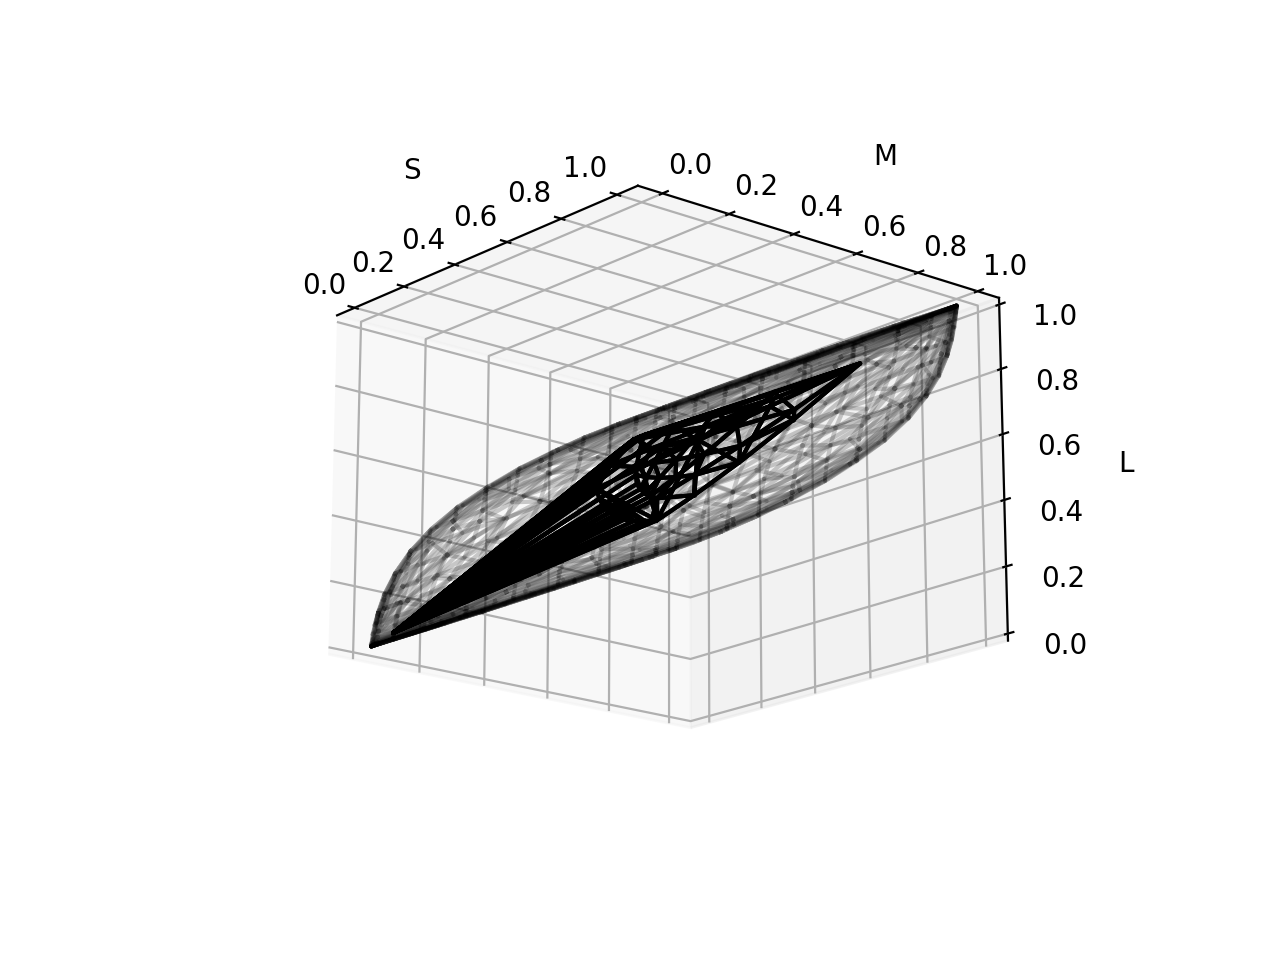

In [29]:
%matplotlib notebook
TRI_GAMUT_POINTS = trichromat.get_full_colors().T

fig, ax = plot_pointcloud_hull(TRI_INK_EXPANDED_GAMUT)
plot_pointcloud_hull(TRI_GAMUT_POINTS, fig=fig, ax=ax, alpha=0.1)
plt.show()

The bottom of the gamut looks fucked up since we are heavily simplifying 3+ inks (and therefore any dark combination) as being the same as CMY. Of course this is not true. But in practice this only serves to reduce the size of the gamut and make our search more conservative.

## Tetrachromat Ink Gamut Metamers

Rerunning above code with a slightly finer comb. Takes about 8 minutes on my system.

In [48]:
TETRA_INK_EXPANDED_GAMUT = np.load("tetra_ink_expanded_gamut12.npy")
TETRA_INK_EXPANDED_GAMUT_KEYS = np.load("tetra_ink_expanded_gamut_keys12.npy")

In [49]:
TETRA_INK_EXPANDED_GAMUT_KEYS.shape

(426860, 6)

In [50]:
TETRA_INK_EXPANDED_GAMUT.shape

(426860, 4)

In [70]:
TETRA_GAMUT_POINTS = tetrachromat.get_full_colors().T
furthest_metamers(TETRA_GAMUT_POINTS, 2, stepsize=0.01)

261724 269465


21.442307029296323

In [66]:
TETRA_GAMUT_POINTS[484234]

array([0.68959974, 0.54702607, 0.60609486, 0.54939838])

In [67]:
TETRA_GAMUT_POINTS[282645]

array([0.65197972, 0.50393393, 0.43442567, 0.50002869])

In [69]:
for ss in [0.001, 0.01, 0.05, 0.1]:
    score = furthest_metamers(TETRA_INK_EXPANDED_GAMUT, 2, stepsize=ss)
    print(score)

229 98341
14.530743424791005
788 48811
5.2643522638635485
56101 51924
1.2171961726335367
786 47493
1.212841600015069


In [71]:
TETRA_INK_EXPANDED_GAMUT_KEYS[788]

array([ 0,  0, 12,  0, 72, 60])

In [89]:
TETRA_INK_EXPANDED_GAMUT[788]

array([0.33314314, 0.43747249, 0.50396046, 0.53620034])

In [72]:
TETRA_INK_EXPANDED_GAMUT_KEYS[48811]

array([ 0, 84, 72,  0,  0,  0])

In [90]:
TETRA_INK_EXPANDED_GAMUT[48811]

array([0.33374125, 0.43395497, 0.48544303, 0.53116827])

In [75]:
m1 = expanded_neugebauer_mix(np.array([ 0,  0, 12,  0, 72, 60]) / 100)
m2 = expanded_neugebauer_mix(np.array([ 0, 84, 72,  0,  0,  0]) / 100)

In [76]:
print(tetrachromat.observe(m1))
print(tetrachromat.observe(m2))

[0.33314314 0.43747249 0.50396046 0.53620034]
[0.33374125 0.43395497 0.48544303 0.53116827]


<IPython.core.display.Javascript object>


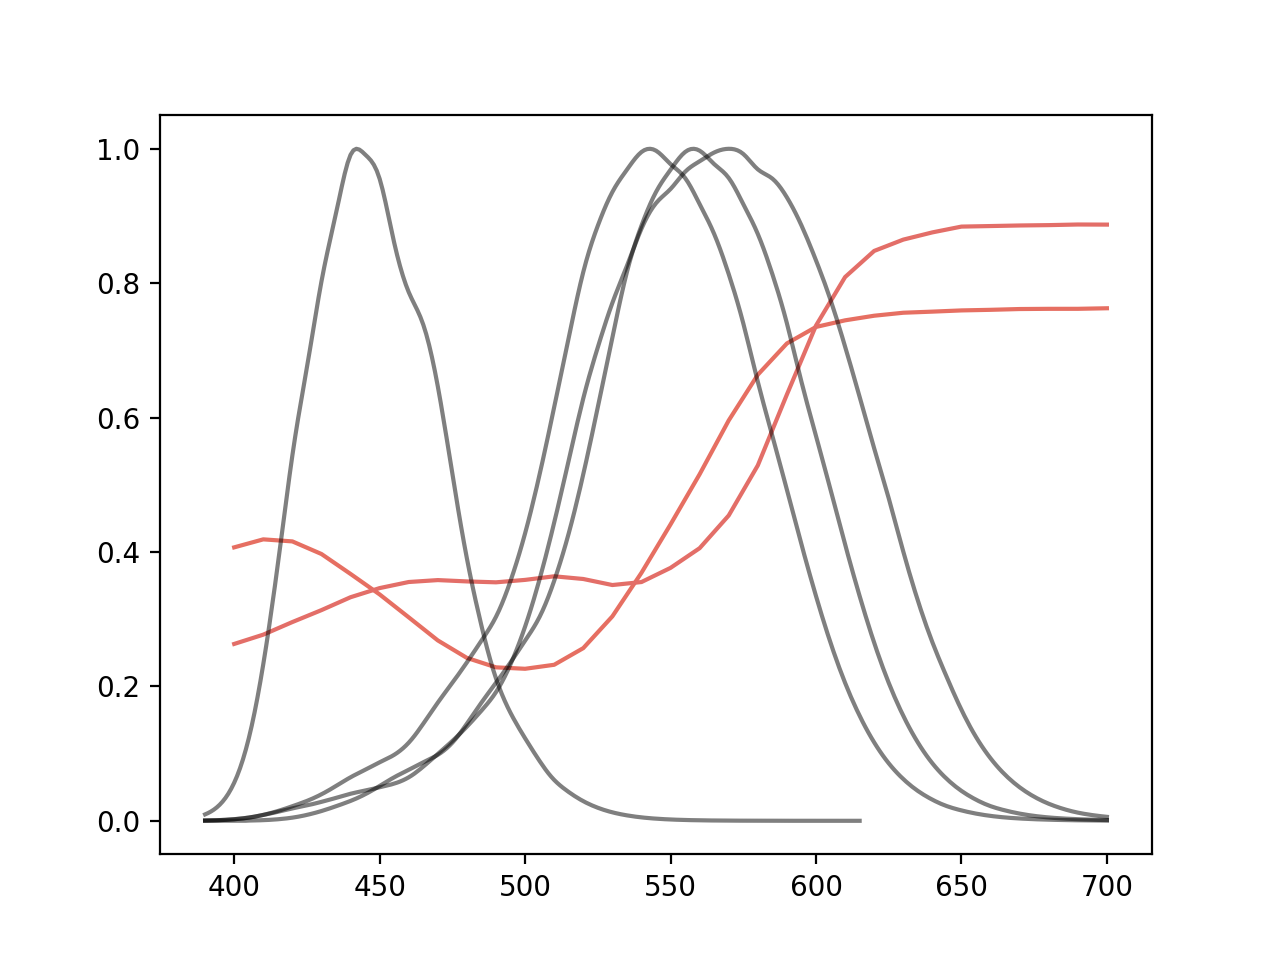

In [84]:
fig7, ax7 = plt.subplots()

m1.plot(ax=ax7)
m2.plot(ax=ax7)
l_cone.plot(ax=ax7,color='black', alpha=0.5)
q_cone.plot(ax=ax7,color='black', alpha=0.5)
m_cone.plot(ax=ax7,color='black', alpha=0.5)
s_cone.plot(ax=ax7,color='black', alpha=0.5)

plt.show()

In [88]:
fig7.savefig("tetrachromat_metamers.png")

I mean that's pretty different. ok let's check it out

In [ ]:
fig2, ax2 = plt.subplots()
expanded_neugebauer_mix(np.array((0, 10, 50, 0, 100, 0)) / 100).plot(ax=ax2)
expanded_neugebauer_mix(np.array((0, 90, 100, 0, 0, 0)) / 100).plot(ax=ax2)
plt.show()

Well... it does seem that those are roughly trichromat metamers.

Score is basically thickness / stepsize
hmmm.. what?
If thickness ~ stepsize then thickness can be account as a basically linear uniform slope of gamut in Q dimension as all (/ maximally increasing) other dimension.

but not necessarily ! as just a linear uniform slope. May also be genuine thickness. impossible to differentiate.

In [ ]:
for stepsize in [0.001, 0.01, 0.02, 0.05, 0.1, 0.5]:
    score = furthest_metamers(TRI_GAMUT_POINTS, 2, stepsize=stepsize)
    print(stepsize, score)

In [ ]:
for stepsize in [0.001, 0.01, 0.02, 0.05, 0.1, 0.5]:
    score = furthest_metamers(TRI_INK_GAMUT, 2, stepsize=stepsize)
    print(stepsize, score)

In [ ]:
for stepsize in [0.001, 0.01, 0.02, 0.05, 0.1, 0.5]:
    score = furthest_metamers(TRI_INK_EXPANDED_GAMUT, 2, stepsize=stepsize)
    print(stepsize, score)

This result implies that our expanded ink gamut somehow shrunk thickness, which should never be the case. This is concerning, but indicative that we are fucking up the expanded gamut in a way. 

- actually, maybe not? I mean the result is confusing but the small stepsizes might be very artifacty. From .05 onward the results are what we'd expect
- implies that the results of 0.05, 0.1, and 0.5 are sort of what we'd want.

In [ ]:
TETRA_GAMUT_POINTS = tetrachromat.get_full_colors().T
for stepsize in [0.001, 0.01, 0.02, 0.05, 0.1, 0.5]:
    score = furthest_metamers(TETRA_GAMUT_POINTS, 2, stepsize=stepsize)
    print(stepsize, score)

In [32]:
for stepsize in [0.001, 0.01, 0.02, 0.05, 0.1, 0.5]:
    score = furthest_metamers(TETRA_INK_EXPANDED_GAMUT, 2, stepsize=stepsize)
    print(stepsize, score)

1293 4896
0.001 3.0644776191823757
708 7468
0.01 1.2020515062492931
1400 2807
0.02 1.349112320056411
141 2180
0.05 1.3473785281838015
141 2716
0.1 1.137857919532842
301 124
0.5 1.0143667669133534


In [ ]:
list(_tetra_ink_expanded_gamut.values())[278]

In [ ]:
list(_tetra_ink_expanded_gamut.values())[4548]

In [ ]:
list(_tetra_ink_expanded_gamut.keys())[278]

In [ ]:
list(_tetra_ink_expanded_gamut.keys())[4548]

In [ ]:
fig3, ax3 = plt.subplots()
expanded_neugebauer_mix(np.array(list(_tetra_ink_expanded_gamut.keys())[278]) / 100).plot(ax=ax3)
expanded_neugebauer_mix(np.array(list(_tetra_ink_expanded_gamut.keys())[4548]) / 100).plot(ax=ax3)

ruh roh .

these results are not great. Hypothesis may be bust. let's investigate 0.05.

In [ ]:
xyz1  = expanded_neugebauer_mix(np.array((0, 10, 50, 0, 100, 0)) / 100).to_xyz()
xyz2 = expanded_neugebauer_mix(np.array((0, 90, 100, 0, 0, 0)) / 100).to_xyz()
print(xyz1, xyz2)

argh! ! ! ! ! ! ! ! !  ! !!  ! ! !!

I don't even have,, a tetrachromat analogue to XYZ to investigate. 

In [ ]:
lms1 =  trichromat.observe(expanded_neugebauer_mix(np.array((0, 10, 50, 0, 100, 0)) / 100))
lms2 = trichromat.observe(expanded_neugebauer_mix(np.array((0, 90, 100, 0, 0, 0)) / 100))
print(lms1, lms2)

"no shit"

In [ ]:
print(np.linalg.norm(lms2 - lms1))

In [ ]:
lqms1 = tetrachromat.observe(expanded_neugebauer_mix(np.array((0, 10, 50, 0, 100, 0)) / 100))
lqms2 = tetrachromat.observe(expanded_neugebauer_mix(np.array((0, 90, 100, 0, 0, 0)) / 100))
print(lqms1, lqms2)
print(np.linalg.norm(lqms2- lqms1))

"buh"

im going totally schiz0 \

ok before i k1ll myself let's go over some options here
- even more expanded ink gamut
- deeper interpolation
- characterizing expanded gamuts in terms of volume
- essential: analyze how correct the gamut expansion is bc the code is pretty sussy (untested) & very mathy. hm, What could be wrong?
- allow 3 colors to mix in a KM away